# Assignment 3 

# Table of Content

## Data Exploration
1. People's Behavior in terms of Dwell Time 
2. Which areas of 307 do people pass through
3. Where do people tend to linger?
4. How does dwell time change over time?

## In-depth Analysis
1. How do different zones affect people's behavior?
2. How do events affect people's behavior?
3. What is the best maintenance strategy?
4. What are other factor affect people's bahavior?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

In [2]:
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
#init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(colorscale='plotly', world_readable=True)

# Extra options
# pd.options.display.max_rows = 30
# pd.options.display.max_columns = 25

# Show all code cells outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import os
from IPython.display import Image, display, HTML

In [3]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [4]:
# store login data in login.py
%run login.py

In [5]:
# login query as multiline formatted string
# this assumes that login and pwd are defined 
# above

loginquery = f"""
mutation {{
  logIn(
      email:\"{login}\",
      password:\"{pwd}\") {{
    jwt {{
      token
      exp
    }}
  }}
}}
"""

In [6]:
import requests
url = 'https://api.numina.co/graphql'

mylogin = requests.post(url, json={'query': loginquery})
# mylogin

In [7]:
token = mylogin.json()['data']['logIn']['jwt']['token']

In [8]:
expdate = mylogin.json()
# expdate

# Context and Preview

The following images present the areas covered by the three devices/cameras:

Streetscape | Under Raincoat | Outside
------------- | -------------  | -------------
![alt](streetscape_sandbox.png) | ![alt](underraincoat_sandbox.png) | ![alt](outside_sandbox.png)

As you see in the above images, each area essentially consists of two parts: objects such as tables and chairs, and empty spaces presumably for walking. Based on this reasoning, we have defined the following smaller behaviour zones so as to perform more in-depth research:

### Streetscape ###

Chair Zone | Corridor Zone | Free Zone
------------- | -------------  | -------------
![alt](BehaviorZoneImage/Streetscape-ChairZone.png) | ![alt](BehaviorZoneImage/Streetscape-PathZone.png) | ![alt](BehaviorZoneImage/Streetscape-ActivityZone.png)

### Under Raincoat ###

Chair Zone | Traffic Zone | Free Zone
------------- | -------------  | -------------
![alt](BehaviorZoneImage/UnderRaincoat-ChairZone.png) | ![alt](BehaviorZoneImage/UnderRaincoat-TrafficZone.png) | ![alt](BehaviorZoneImage/UnderRaincoat-ActivityZone.png)

### Outside ###

Chair Zone | Path Zone | -
------------- | -------------  | -------------
![alt](BehaviorZoneImage/Outside-ChairZone.png) | ![alt](BehaviorZoneImage/Outside-PathZone.png) | ![alt](blank.png)

Note that we have to be aware of the fact that the chairs can be moved and that the above images may not necessarily reflect the layout of the room during the whole period of data collection. Specifically, the three sets of chairs in the Under Raincoat area can be easily moved. Thus, for the purpose of this webpage, we will not be investigating the Chair Zone of Under Raincoat; instead, we will integrate any analysis of the chairs into the analysis of the Free Zone, since it is presumably safe to assume that the chairs would not be moved outside the Free Zone to the Traffic Zone.

Similarly, in the Streetscape area, under the assumption that it is intended to place the chairs together, it is unlikely that the group of chairs would be moved around freely and frequently due to the other obstacles in the room. As for the Outside area, it is also unlikely that the chairs would be placed in the middle of the road to block the path. Thus, we will be analyzing these two Chair Zones (while keeping the limitation in mind).

# Patterns in Pedestrian Count and Dwell Time

In [9]:
# device info
device_dict = {'SWLSANDBOX1':'Streetscape', 'SWLSANDBOX2':'Under Raincoat', 'SWLSANDBOX3':'Outside'}
device_ids = list(device_dict.keys())
device_names = list(device_dict.values())

In [10]:
def get_zones(device_id):
    '''
    a query to get all zones within the areas included in the device_id list;
    returns a df
    '''
    query_zones = """
    query {{
      behaviorZones (
        serialnos: "{0}"
        ) {{
        count
        edges {{
          node {{
            rawId
            text
          }}
        }}
      }}
    }}
    """.format(device_id)
    
    zones = requests.post(url, json={'query': query_zones}, headers = {'Authorization':token})
    
    df = pd.DataFrame([x['node'] for x in zones.json()['data']['behaviorZones']['edges']])
    df['device_id'] = device_id
    
    return df

In [11]:
# creates a df for zones

# get zones
zones_df = pd.concat([get_zones(device_ids[i]) for i in range(3)])
zones_df = zones_df[(zones_df.text.notnull()) & 
                    (zones_df.text.str.startswith('x-')) & 
                    (zones_df.text.str.endswith('zone'))]

In [12]:
# adjusts zone info

# modify zone name and add a type
zones_df['text'] = zones_df['text'].str.replace('x-', '')
zones_df['type'] = ['path', 'rest', 'both', 'path', 'both', 'rest', 'path']

# colour of zones - 3 blues, 2 reds, 2 greens
zone_clrs = ['royalblue', 'deepskyblue', 'dodgerblue',
             'lightcoral', 'orangered', 
             'mediumaquamarine', 'mediumseagreen']

# zone ID from int to str
zones_df.rawId = zones_df.rawId.astype(str)
zone_name_dict = dict(zip(zones_df.rawId, zones_df.text))
zone_type_dict = dict(zip(zones_df.rawId, zones_df.type))

In [13]:
def get_dwell(func, ID, interval):
    '''
    func is either feedDwellTimeDistribution or zoneDwellTimeDistribution;
    a query to get dwell info in area/zone identified by ID;
    returns a preprocessed dataframe
    '''
    if func == 'feedDwellTimeDistribution':
        arg = 'serialnos: "{0}"'.format(ID)
    else:
        arg = 'zoneIds: {0}'.format(ID)
        
    query = """
    query {{
        {0}(
        {1},
        startTime: "2019-02-20T00:00:00",
        endTime: "2020-01-12T00:00:00",
        timezone: "America/New_York",
        objClasses: ["pedestrian"],
        interval: "{2}"
        ){{
        edges {{
          node {{
            time
            objClass
            pct100
            pct75
            pct50
            pct25
            mean
            count
          }}
        }}
      }}
    }}
    """.format(func, arg, interval)

    dwell = requests.post(url, json={'query': query}, 
                           headers = {'Authorization':token})
    
    # traverse to only keep useful info
    df = pd.DataFrame([x['node'] for x in dwell.json()['data'][func]['edges']])
    # add a column
    if func == 'feedDwellTimeDistribution':
        df['device_id'] = ID
    else:
        df['zone_id'] = ID
    
    return df

In [14]:
def preprocess(df):
    '''
    preprocesses a dataframe returned by feedDwellTimeDistribution/zoneDwellTimeDistribution
    '''
    # replace NaN with 0
    df = df.fillna(0)
    # convert time
    df['time'] = df['time'].str[:-6].apply(lambda x : pd.Timestamp(x))
    df['month'] = df['time'].dt.month
    df['dayofweek'] = df['time'].dt.dayofweek
    df['hour'] = df['time'].dt.hour
    df['date'] = df['time'].dt.date
    
    # add either zone or device name
    if 'zone_id' in df.columns:
        df.zone_id = df.zone_id.astype(str)
        df['zone'] = [zone_name_dict[z] for z in df.zone_id]
        df['zone_type'] = [zone_type_dict[z] for z in df.zone_id]
    else:
        df['device'] = [device_dict[d] for d in df.device_id]
    
    # add a total column = mean * count
    df['total_dwell'] = df['mean'] * df['count']
    df = df.rename(columns={'mean':'mean_dwell', 'pct50':'median_dwell', 'pct100':'max_dwell'})
    df = df.drop(['pct75', 'pct25'], axis=1)
    
    return df

In [15]:
# hourly dwell time 
# device
feed_dwell_1h_df = pd.concat([get_dwell('feedDwellTimeDistribution', device_ids[i], '1h') 
                              for i in range(3)])
# zone
zone_dwell_1h_df = pd.concat([get_dwell('zoneDwellTimeDistribution', z, '1h')
                             for z in zones_df['rawId'].values])
feed_dwell_1h_df = preprocess(feed_dwell_1h_df)
zone_dwell_1h_df = preprocess(zone_dwell_1h_df)

In [16]:
# daily dwell time 
# device
feed_dwell_1d_df = pd.concat([get_dwell('feedDwellTimeDistribution', device_ids[i], '1d') 
                              for i in range(3)])
# zone
zone_dwell_1d_df = pd.concat([get_dwell('zoneDwellTimeDistribution', z, '1d')
                             for z in zones_df['rawId'].values])
feed_dwell_1d_df = preprocess(feed_dwell_1d_df)
zone_dwell_1d_df = preprocess(zone_dwell_1d_df)

In [17]:
def get_df(groupby, interval):
    '''
    helper function to be called by other functions
    '''
    if groupby == 'device' and interval == '1d':
        return feed_dwell_1d_df.copy(), device_names
    elif groupby == 'zone' and interval == '1d':
        return zone_dwell_1d_df.copy(), list(zones_df.text)
    elif groupby == 'device' and interval == '1h':
        return feed_dwell_1h_df.copy(), device_names
    elif groupby == 'zone' and interval == '1h':
        return zone_dwell_1h_df.copy(), list(zones_df.text)

As a starting point, we will use the following interactive line plot to explore the trend in pedesdrian count / dwell time in different areas / zones over the past year. We suggest to focus on comparing across the three areas (i.e. 'groupby' = 'device'). 

Tip: You can click the legend on the right to include/exclude a line on the plot.

In [18]:
metric_list = ['count', 'mean_dwell', 'max_dwell', 'median_dwell', 'total_dwell']

In [35]:
def plot_timeline(groupby, metric):
    '''
    groupby is either 'device' or 'zone';
    metric is a value in metric_list
    '''
    df, _ = get_df(groupby, '1d')
    
    # line plot
    fig = px.line(df, x='time', y=metric, color=groupby, 
                  title='Trend in Daily Pedestrian ' +\
                        metric.replace('_', ' ').title() + ' Grouped by '+groupby.capitalize())
    
    # layout - axes labels
    fig.update_layout(
        xaxis_rangeslider_visible=True
    )
    
    fig.show()
    

In [36]:
_ = interact(plot_timeline, 
             groupby=widgets.RadioButtons(options=['device', 'zone'], value='device'),
             metric=widgets.Dropdown(options=metric_list, value='mean_dwell')
            )

interactive(children=(RadioButtons(description='groupby', options=('device', 'zone'), value='device'), Dropdow…

As a general observation, there is not obvious increasing/decreasing trend (but rather frequent ups and downs) in any of the metric in the past year.

We observe the count (and thus the total dwell time) in the Streetscape area has been siginificantly higher than the other two areas. Meanwhile, we see that peaks in mean dwell time tended to occur in Streetscape, and peaks in max dwell time tended to occur in either Streetscape or Outside. From either perspective, the Under Raincoat area is not as popular.

If you are interested in researching about the reason about the peaks, the following interactive dataframe summarizes the exact locations and dates:

In [37]:
def sort_dwell_1d(groupby, sortby, ascending, top):
    '''
    display a dataframe summarizing the area/zone and times of the top days
    in either descending or ascending order
    '''
    df, _ = get_df(groupby, '1d')
    
    # weekday name
    df['dayofweek'] = df['time'].dt.day_name()
    
    # column list
    cols = [groupby, 'time', 'dayofweek', sortby]
    if sortby == 'count':
        cols.append('mean_dwell')
    elif sortby == 'mean_dwell':
        cols.append('count')
    else:
        cols.append('count')
        cols.append('mean_dwell')
        
    display(df.sort_values(sortby, ascending=ascending).reset_index(drop=True)
              .loc[:int(top)-1, cols])

_ = interact(sort_dwell_1d, 
             groupby=widgets.RadioButtons(options=['device', 'zone'], value='device'),
             sortby=widgets.Dropdown(options=metric_list, value='mean_dwell'),
             top=widgets.IntSlider(value=5, min=1, max=30, step=1, readout_format='d'),
             ascending=widgets.Checkbox(value=False, description='ascending'))

interactive(children=(RadioButtons(description='groupby', options=('device', 'zone'), value='device'), Dropdow…

If, in addition to general observations, you are also interested in comparing the statistics/distribution of a metric across the three areas (ex. the medians of mean dwell time), the following boxplots would be very useful. As mentioned, we highly recommend to focus on device groups only at this point.

In [33]:
def plot_boxplot(groupby, metric):
    '''
    plots box plot distribution of metric in metric list
    '''
    fig = go.Figure()
    
    # colours
    if groupby == 'zone':
        clrs = zone_clrs
    else:
        # default colours in sequence named plotly
        # to be consistent
        clrs = ['#636DFA', '#EF553B', '#00CC96']
        
    df, byvals = get_df(groupby, '1d')
    
    for i in range(len(byvals)):
        # Use x instead of y argument for horizontal plot
        fig.add_trace(go.Box(x=df.loc[df[groupby]==byvals[i], metric], name=byvals[i],
                             boxpoints='outliers', boxmean=True, marker_color=clrs[i]))

    # layout - axes labels
    fig.update_layout(
        xaxis_title=metric,
        xaxis_rangeslider_visible=True,
        title='Distribution of Pedestrian ' + \
              metric.replace('_', ' ').title() + ' Grouped by Device'
    )
    
    fig.show()
    

In [34]:
_ = interact(plot_boxplot, groupby=widgets.RadioButtons(options=['device', 'zone'], value='device'),
             metric=widgets.Dropdown(options=metric_list, value='count')
            )

interactive(children=(RadioButtons(description='groupby', options=('device', 'zone'), value='device'), Dropdow…

As we are working with time series data, it is natural to see the effects of different time groups (ex. hours, weekdays, months). We have obtained daily and hourly data. We decided to use 'mean_dwell' as a representative for dwell time data; then we picked 'hour' and 'dayofweek' for hourly data and 'dayofweek' and 'month' for daily data to create the following matrix:

We suggest to focus on the subplots in the upper triangle. 

From the hourly data, we observe that 'hour' is a significant factor affecting the number of pedestrians passing through (but we cannot tell whether it is true for the dwell time). As we would expect, counts are mostly 0 early in the morning (e.g. before 6am) and reach the peak in the afternoon. We also observe that the outliers / extreme values in 'hourly count' tended to occur on Saturday in the Streetscape (i.e. indoor) area. 

If we compare and contrast the individual distributions of count and mean_dwell, we see that both are right-skewed. However, the distribution of mean dwell time has a much thinner tail, suggesting that mean dwell time tended to be very similar across different hours and days while the count varies more; meanwhile, only the distribution of count suggests that the Streetscape area is significantly more popular than the other two. As a result, we see that the scatter plot between count and mean_dwell shows an 'L' shape, showing that there did not exist an hour in which both the count and mean dwell time are high. In fact, if you hover over the four points with the highest mean_dwell value, you would see that they all have a count of 1. In addition, the plot suggests a weak to no correlation between the two attributes.

Then if we switch to the daily data, the distributions of the count and the mean dwell time are still right-skewed (but with less variation) and still no obvious correlation is exhibited. Solely based on the above scatterplot, since most points overlap, we cannot conclude that 'month' or 'dayofweek' is an important factor affecting the daily data. 

The scatter matrices aim to provide an overall picture and give some guidance for the directions of further exploration. 

Recall that we observed that 'hour' tended to have an impact on at least pedestrian count and we still need to explore the effects of 'dayofweek' and 'month'. Thus, we recommend to explore the data with the following grouped bar plots, which uses hourly data for the 'hour' time group and daily data for the others:

In [41]:
def plot_timegroup(groupby, metric, timegroup):
    '''
    plots metric of each groupby ('device' or 'zone') 
    by timegroup ('hour', 'date', 'dayofweek', 'month')
    using a grouped barplot
    '''
    # get either 1d or 1h depending on time group
    if timegroup == 'hour':
        df, byvals = get_df(groupby, '1h')
    else:
        df, byvals = get_df(groupby, '1d')
    
    # colours
    if groupby == 'device':
        # default colours
        clr = None
    else:
        clr = zone_clrs
        
    # convert dayofweek
    weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
    df['dayofweek'] = [weekdays[w] for w in df['dayofweek']]
    
    # group
    df = df.groupby([timegroup, groupby]).median().reset_index()
    
    # plot
    fig = px.bar(df, x=timegroup, y=metric, color=groupby,
                 category_orders={groupby:byvals, 'dayofweek':list(weekdays.values())}, # order of categories
                 color_discrete_sequence=clr, # colour of devices/zones
                 title='Median of Pedestrian ' + metric.replace('_', ' ').title() + ' Grouped by ' +\
                        timegroup.title() + ' and ' + groupby.title(),
                 barmode='group')
    fig.show()

In [42]:
_ = interact(plot_timegroup, 
             groupby=widgets.RadioButtons(options=['device', 'zone'], value='device'),
             metric=widgets.Dropdown(options=metric_list, value='count'),
             timegroup=widgets.Dropdown(options=['hour', 'dayofweek', 'month'], value='dayofweek'))

interactive(children=(RadioButtons(description='groupby', options=('device', 'zone'), value='device'), Dropdow…

Looking at the median value of daily pedestrian data statistics grouped by weekdays, we observe surprisingly that Saturday is a very special day, in which both the count and (mean/max) dwell time in the Streetscape (indoor) area are significantly less than the other days of the week.

As for 'month', we see that in more than half of the days in Febraury, March, April and May, no pedestrians have been detected in the Outside area; similarly, there were no pedestrians in the Under Raincoat area in more than half of the days in November to March. 

The reasons behind these observations are not clear without further information such as maintenance schedule of the devices/cameras. We highly encourage you to investigate the reasons behind having no visits if the cameras were actually in service. 

On the other hand, it is more reasonable to see the median values of 'count' being all 0 from 11pm to 6am. We observe a normal distribution for the count in the Outside and Under Raincoat areas but a gap between 5pm and 8pm for the Streetscape area. 

Now in place of the exact values of the metrics, let's look at the proportions (in terms of pedestrian count and total dwell time):

If we consider all data together, then the Streetscape area accounted for about 77.2% of all dwell time in the 307, followed by Outside (14.8%) and Under Raincoat (8%). By comparing the two pie charts, we could also conclude that the dwell time on average tended to be longer in the Under Raincoat area than in the Outside area.

Now let's look at the proportions in more details.

In [45]:
def compute_prop_helper(df, col, newcol, lower_bound):
    '''
    helper function for compute_prop;
    newcol is proportion wrt col
    '''
    # group by time (date + hour)
    m = df.groupby('time').sum()
    
    # compute proportion wrt the total at each time
    # add 0.00001 to avoid division by zero
    df[newcol] = df.apply(lambda x : x[col] / (0.00001 + m.loc[x['time'], col]), axis=1)
    
    # only keep the times where the total count/dwell time is at least lower_bound
    sub = df[df['time'].isin(list(m[m['count']>=lower_bound].index))]
    
    return sub

In [46]:
def compute_prop(df, lower_bound):
    '''
    computes proportion of count and total_dwell wrt the total at the time;
    only keep days/hours in which the total value is at least lower_bound;
    adds two new columns - count_prop and total_dwell_prop
    '''
    df = df.copy()
    df = compute_prop_helper(df, 'count', 'count_prop', lower_bound)
    df = compute_prop_helper(df, 'total_dwell', 'total_dwell_prop', lower_bound)
    return df

In [49]:
def plot_prop(groupby, metric, timegroup, lower_bound):
    '''
    plots proportion of metric ('count' or 'total_dwell')
    of each groupby ('device' or 'zone') 
    by timegroup ('hour', 'date', 'dayofweek', 'month');
    lower_bound is on the total value at a time
    '''
    # get either 1d or 1h depending on time group
    if timegroup == 'hour':
        df, byvals = get_df(groupby, '1h')
    else:
        df, byvals = get_df(groupby, '1d')
    
    # colours
    if groupby == 'device':
        # default colours
        clr = None
    else:
        clr = zone_clrs
        
    # order of dayofweek
    weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
    df['dayofweek'] = [weekdays[w] for w in df['dayofweek']]
    
    # add proportion columns
    df = compute_prop(df, lower_bound)
    # group
    df = df.groupby([timegroup, groupby]).mean().reset_index()
    
    # plot
    fig = px.bar(df, x=timegroup, y=metric+'_prop', color=groupby,
                 category_orders={groupby:byvals, 'dayofweek':list(weekdays.values())}, # order of categories
                 color_discrete_sequence=clr, # colour of devices/zones
                 title='Averaged Proportion of ' + metric.replace('_', ' ').title() +\
                       ' Accounted for by Each ' + groupby.title(),
                 range_y=(0, 1), labels={metric+'_prop':metric.replace('_', ' ')+' proportion'})
    fig.show()

In [50]:
_ = interact(plot_prop, 
             groupby=widgets.RadioButtons(options=['device', 'zone'], value='zone'),
             metric=widgets.RadioButtons(options=['count', 'total_dwell'], value='total_dwell'),
             timegroup=widgets.Dropdown(options=['hour', 'date', 'dayofweek', 'month'], value='hour'),
             lower_bound=widgets.IntSlider(value=50, min=0, max=2000, step=50, continuous_update=False))

interactive(children=(RadioButtons(description='groupby', index=1, options=('device', 'zone'), value='zone'), …

Tip: blues are Streetscape zones, reds are Under Raincoat zones and greens are Outside zones.

From the above stacked bar plots, the most obvious observation is the special pattern on Saturday as described previously. 

In addition, while both the Outside and the Streescape areas have a chair zone of a similar size, the chair zone in the Streetscape area tended to account for much more of the data in the area (roughly 1/3) in comparison to that in the Outside zone (roughly 1/10). 

We see that on average, the Under Raincoat area accounted for more proportion of both total count and total dwell time in the evening than in the daytime. We notice that during these evening hours in the Under Raincoat area, the proportion of the free zone (i.e. where people tended to sit and stay) tended to be even greater in comparison to other hours. On the other hand in the other two areas, the proportion taken by the chair zone tended to decrease in comparison to daytime. 

### Obtain heatmap for pedestrians

In [34]:
from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta
import calendar

START_DATE = datetime(2019, 2, 20, 0, 0, 0)
END_DATE = datetime(2020, 1, 11, 0, 0, 0)
time_delta = relativedelta(days = +1)

In [35]:
## fundatmental functions to get the heatmap data 
def heatmap_query_gen(startTime: str, endTime: str, camera:int, obj:str):
    '''
    for generating heatmap query given time, device, and object
    '''
    heatmap_query = """
query {{
  feedHeatmaps(
    serialno: "{0}",
    startTime:"{1}",
    endTime:"{2}",
    objClasses:["{3}"],
    timezone:"America/New_York") {{
    edges {{
      node {{
        time
        objClass
        heatmap
      }}
    }}
  }}
}}
""".format(camera, startTime, endTime,obj)
    return heatmap_query

In [36]:
def get_heatmap_data(camera: int, obj: str, start_times:list, end_times:list):
    '''
    get the heatmap matrix raw dataframe using  heatmap_query_gen as a helper
    '''
    heatmap_df = pd.DataFrame(columns = ['startTime', 'endTime', 'heatMap', 'obj'])
    i = 0
    while i < len(start_times):
        heatmap_data = requests.post(url, 
                                     json={'query': heatmap_query_gen(start_times[i].strftime('%Y-%m-%dT%H:%M:%S'), 
                                                                      end_times[i].strftime('%Y-%m-%dT%H:%M:%S'), 
                                                                      camera, obj)},
                                     headers = {'Authorization':token})
        heatmap_json = heatmap_data.json()
        if heatmap_json['data']:
            if 'feedHeatmaps' in heatmap_json['data']:
                heatmap = heatmap_json['data']['feedHeatmaps']['edges'][0]['node']['heatmap']
                temp_df = pd.DataFrame({"startTime":start_times[i], "endTime":end_times[i], 'heatMap':heatmap, 'obj': obj})
                heatmap_df = heatmap_df.append(temp_df, ignore_index = True)
        i = i + 1
    return heatmap_df

In [37]:
def generate_consecutive_times(start_time: datetime, end_time: datetime, interval: relativedelta):
    '''
    for generating consecutive datetime objects between start_time and end_time
    '''
    ## the first element in the list are the start times
    time = [[], []]
    current_time = start_time
    while current_time < end_time:
        time[0].append(current_time)
        time[1].append(current_time + interval)
        current_time = current_time + interval
    return time

In [38]:
def daily_heatmap_data(df):
    '''
    merge the raw heatmap data by day(time)
    '''
    return df.groupby(['startTime', 'endTime'])['heatMap'].apply(list).reset_index(name='heatMapMatrix')

In [118]:
## load the data, it takes a lot of time, so we do it camera by camera
all_time = generate_consecutive_times(START_DATE, END_DATE, time_delta)
outside_heatmap_pedestrian = daily_heatmap_data(get_heatmap_data('SWLSANDBOX3', 'pedestrian', all_time[0], all_time[1]))

In [ ]:
streetscape_heatmap_pedestrian = daily_heatmap_data(get_heatmap_data('SWLSANDBOX1', 'pedestrian', all_time[0], all_time[1]))

In [ ]:
underraincoat_heatmap_pedestrian_1 = daily_heatmap_data(get_heatmap_data('SWLSANDBOX2', 'pedestrian', all_time[0][0:100], all_time[1][0:100]))

In [ ]:
underraincoat_heatmap_pedestrian_2 = daily_heatmap_data(get_heatmap_data('SWLSANDBOX2', 'pedestrian', all_time[0][100:200], all_time[1][100:200]))

In [ ]:
underraincoat_heatmap_pedestrian_3 = daily_heatmap_data(get_heatmap_data('SWLSANDBOX2', 'pedestrian', all_time[0][200:], all_time[1][200:]))

In [ ]:
underraincoat_heatmap_pedestrian = underraincoat_heatmap_pedestrian_1.append(
    underraincoat_heatmap_pedestrian_2).append(
    underraincoat_heatmap_pedestrian_3).reset_index(drop = True)

In [ ]:
## join two dataframes (dwell data and heatmap)
streetscape_pedestrian_data_all = pd.merge(feed_dwell_1d_df[feed_dwell_1d_df['device'] == 'SWLSANDBOX1'], streetscape_heatmap_pedestrian, left_on = "time", right_on = "startTime")
underraincoat_pedestrian_data_all = pd.merge(feed_dwell_1d_df[feed_dwell_1d_df['device'] == 'SWLSANDBOX2'], underraincoat_heatmap_pedestrian, left_on = "time", right_on = "startTime")
outside_pedestrian_data_all = pd.merge(feed_dwell_1d_df[feed_dwell_1d_df['device'] == 'SWLSANDBOX3'], outside_heatmap_pedestrian, left_on = "time", right_on = "startTime")

In [ ]:
def week_days(lis, weekday):
     '''
    This function is for generating a given weekday within a time period
    '''
    days = []
    for day in lis:
        if day.weekday() == weekday:
            days.append(day)
    return days

In [ ]:
event_days = [datetime(2019, 3, 2, 0, 0, 0), datetime(2019, 6, 29, 0, 0, 0), datetime(2019, 8, 15, 0, 0, 0), datetime(2019, 9, 26, 0, 0, 0), 
                    datetime(2019, 11, 20, 0, 0, 0), datetime(2019, 11, 21, 0, 0, 0), datetime(2019, 11, 22, 0, 0, 0), datetime(2019, 11, 23, 0, 0, 0)] ## sorted by number of people
saturdays = week_days(all_time[0], 5)
sundays = week_days(all_time[0], 6)
mondays= week_days(all_time[0], 0)
tuesdays = week_days(all_time[0], 1)
wednesdays = week_days(all_time[0], 2)
thursdays = week_days(all_time[0], 3)
fridays = week_days(all_time[0], 4)
weekday = [mondays, tuesdays, wednesdays, thursdays, fridays]
weekdays = []
for day in weekday:
    weekdays.extend(day)

In [ ]:
# Plot streetscape heatmap
# First, check how many plots the audience wants to show, input p
# Then, let the user to choose the day: IntRangeSlider
def get_daily_matrix(day: datetime, percentile: int, camera: str):
    data = []
    if camera == 'Outside Camera':
        data = list(outside_heatmap_pedestrian[outside_heatmap_pedestrian['startTime'] == day]['heatMapMatrix'])
    elif camera == 'StreetScape Camera':
         data = list(streetscape_heatmap_pedestrian[streetscape_heatmap_pedestrian['startTime'] == day]['heatMapMatrix'])
    elif camera == 'UnderRainCoat Camera':
        data = list(underraincoat_heatmap_pedestrian[underraincoat_heatmap_pedestrian['startTime'] == day]['heatMapMatrix'])
    if data: 
        p = np.percentile([i[2] for i in data[0]], percentile)
        filtered = list(filter(lambda x : x[2] >= p, data[0]))
        x = [i[0] for i in filtered] 
        y = [i[1] for i in filtered]
        density = [i[2] for i in filtered]
        return [x, y, density]
    else:
        return []
def handle_not_exist_day(day):
    print('There is no pedestrian recorded on {0}.{1}.{2}, please select another day.'.format(day.year, day.month, day.day))
def plot_streetscape_heatmap(percentile, day1:datetime, day2:datetime, day3: datetime, day4: datetime,
                             day5:datetime, day6:datetime, day7: datetime, day8: datetime, day9: datetime, mode: str, camera: str):
    fig = plt.figure(figsize=(16,11))
    days = [day1, day2, day3, day4, day5, day6, day7, day8, day9]
    if camera == "Outside Camera":
        image = mpimg.imread('outside_sandbox.png')
    elif camera == "StreetScape Camera":
        image = mpimg.imread('streetscape_sandbox.png')
    elif camera == "UnderRainCoat Camera":
        image = mpimg.imread('underraincoat_sandbox.png')
    if mode == "Days with the most dwell counts":
        days = days
    elif  mode == "Days with the highest mean dwell time":
        days = days
    elif mode == "Event Days with most pedestrian":
        days = days
    elif mode == "Customize":
         days = days
    axes = []
    for i in range(0,9):
        day_data = get_daily_matrix(days[i], percentile, camera)
        ax = fig.add_subplot(3, 3, i+1)
        axes.append(ax)
        if not (day_data):
            handle_not_exist_day(days[i])
        else:
            ax = fig.add_subplot(3, 3, i+1)
            ax.scatter(day_data[0], y = day_data[1], c=day_data[2], s=1, cmap= plt.cm.nipy_spectral)
        ax.imshow( image, aspect='auto')
        ax.set_title("Heatmap on {0}.{1}.{2}".format(days[i].year, days[i].month, days[i].day))
        ax.axis('off')
widgets.interact_manual(plot_streetscape_heatmap, day1=widgets.DatePicker(value=pd.to_datetime('2019-02-20')), 
                                                              day2=widgets.DatePicker(value=pd.to_datetime('2019-02-21')),
                                                              day3=widgets.DatePicker(value=pd.to_datetime('2019-02-22')),
                                                              day4=widgets.DatePicker(value=pd.to_datetime('2019-02-23')), 
                                                              day5=widgets.DatePicker(value=pd.to_datetime('2019-02-20')), 
                                                              day6=widgets.DatePicker(value=pd.to_datetime('2019-02-21')),
                                                              day7=widgets.DatePicker(value=pd.to_datetime('2019-02-22')),
                                                              day8=widgets.DatePicker(value=pd.to_datetime('2019-02-23')), 
                                                              day9=widgets.DatePicker(value=pd.to_datetime('2019-02-23')), 
                                                              percentile = widgets.IntSlider(min=0, max=100, step=5, value=0),
                                                              mode = widgets.Dropdown(options=[("Days with the most dwell counts", "Days with the most dwell counts"),
                                                                                               ("Days with the highest mean dwell time", "Days with the highest mean dwell time"),
                                                                                               ("Event Days with most pedestrian", "Event Days with most pedestrian"),
                                                                                               ("Customize", "Customize")],description='Plots:'),
                                                               camera = widgets.Dropdown(options=["Outside Camera", "StreetScape Camera", "UnderRainCoat Camera"]))



In [ ]:
# Initialize time data for loading the data
# I want to load hourly data on 2019.6.29 as Initialization
start_time = datetime(2019, 6, 29, 0, 0, 0)
end_time = datetime(2019, 6, 30, 0, 0, 0)
interval =  relativedelta(hours = +1)
hour_interval = generate_consecutive_times(start_time, end_time, interval)

In [ ]:
def add_column(data, date, camera, t):
    '''
    This is a simple wrapper function for creating columns
    '''
    data["date"] = date
    data["camera"] = camera
    data["type"] = t
    return data

In [ ]:
## Initialize the hourly heatmap data for streetscape
streetscape_heatmap_pedestrian_event_days = daily_heatmap_data(get_heatmap_data('SWLSANDBOX1', 'pedestrian', hour_interval[0], hour_interval[1]))
streetscape_heatmap_pedestrian_event_days =  add_column(outside_heatmap_pedestrian_event_days,  datetime(2019, 6, 29, 0, 0, 0), "outside", "pedestrian")

In [ ]:
## Initialize the hourly heatmap data for outside
outside_heatmap_pedestrian_event_days  = daily_heatmap_data(get_heatmap_data('SWLSANDBOX3', 'pedestrian', hour_interval[0], hour_interval[1]))
outside_heatmap_pedestrian_event_days = add_column(outside_heatmap_pedestrian_event_days,  datetime(2019, 6, 29, 0, 0, 0), "outside", "pedestrian")

In [ ]:
## Initialize the hourly heatmap data for underraincoat
underraincoat_heatmap_pedestrian_event_days  = daily_heatmap_data(get_heatmap_data('SWLSANDBOX2', 'pedestrian', hour_interval[0], hour_interval[1]))
underraincoat_heatmap_pedestrian_event_days = add_column(underraincoat_heatmap_pedestrian_event_days,  datetime(2019, 6, 29, 0, 0, 0), "underraincoat", "pedestrian")

In [ ]:
## Loading event hourly heatmap data for streetscape
start_time = datetime(2019, 6, 29, 0, 0, 0)
for day in event_days:
    if day != start_time:
        start_time = day
        end_time = start_time + relativedelta(days = +1)
        hour_interval = generate_consecutive_times(start_time, end_time, interval)
        temp = add_column(daily_heatmap_data(get_heatmap_data('SWLSANDBOX1', 'pedestrian', hour_interval[0], hour_interval[1])), start_time,  'streetscape', 'pedestrian')
        streetscape_heatmap_pedestrian_event_days = streetscape_heatmap_pedestrian_event_days.append(temp)

In [ ]:
## Loading event hourly heatmap data for underraincoat
start_time = datetime(2019, 6, 29, 0, 0, 0)
for day in event_days:
    if day != start_time:
        start_time = day
        end_time = start_time + relativedelta(days = +1)
        hour_interval = generate_consecutive_times(start_time, end_time, interval)
        temp = add_column(daily_heatmap_data(get_heatmap_data('SWLSANDBOX2', 'pedestrian', hour_interval[0], hour_interval[1])), start_time,  'underraincoat', 'pedestrian')
        underraincoat_heatmap_pedestrian_event_days = underraincoat_heatmap_pedestrian_event_days.append(temp)

In [ ]:
## Loading event hourly heatmap data for outside
start_time = datetime(2019, 6, 29, 0, 0, 0)
for day in event_days:
    if day != start_time:
        start_time = day
        end_time = start_time + relativedelta(days = +1)
        hour_interval = generate_consecutive_times(start_time, end_time, interval)
        temp = add_column(daily_heatmap_data(get_heatmap_data('SWLSANDBOX3', 'pedestrian', hour_interval[0], hour_interval[1])), start_time,  'outside', 'pedestrian')
        outside_heatmap_pedestrian_event_days = outside_heatmap_pedestrian_event_days.append(temp)

In [ ]:
## This is a helper function for getting the data for plotting hourly heatmap
def event_hour_data_helper(camera, percentile, time):
    '''
    This is a simple helper function to get the data
    camera is required to be "Outside Camera" or  "StreetScape Camera" or  "UnderRainCoat Camera"
    percentile is required to be an integer between 0 and 100
    time is required to be a datetime object on event days
    Return Value for this function will be like [[1, 3, ...,],[2, 1, ...],[12, 0.2,...]] 
    A list containing 3 sublists the first represent x, second for y, third for density, they have to be in the same length
    '''
    data = []
    if camera == "Outside Camera":
        data = outside_heatmap_pedestrian_event_days
    elif camera == "StreetScape Camera":
        data = streetscape_heatmap_pedestrian_event_days
    elif camera == "UnderRainCoat Camera":
        data = underraincoat_heatmap_pedestrian_event_days
    data = list(data[data['startTime'] == time]['heatMapMatrix'])
    if data:
        p = np.percentile([i[2] for i in data[0]], percentile)
        filtered = list(filter(lambda x : x[2] >= p, data[0]))
        x = [i[0] for i in filtered] 
        y = [i[1] for i in filtered]
        density = [i[2] for i in filtered]
        data = [x, y, density]
    return data

In [ ]:
## heatmap_animation_hour("StreetScape Camera", start_time, 20, 12)
## User is able to select the event day, percentile,
def heatmap_animation_hour(camera: str, day: datetime, percentile: int, hour: int):
    '''
    This is a function for plotting hourly heatmap on event days
    day is required to be one of the event days
    camera is required to be "Outside Camera" or  "StreetScape Camera" or  "UnderRainCoat Camera"
    percentile is required to be an integer between 0 and 100
    hour is required to be an interger between 0 to 23
    The function will plot a heatmap given the day and hour, only keeps the data points above the percentile
    '''
    hour_interval =  relativedelta(hours = +1)
    fig, ax = plt.subplots(figsize=(15,10))
    
    # Setting Background Image
    if camera == "Outside Camera":
        image = mpimg.imread('outside_sandbox.png')
    elif camera == "StreetScape Camera":
        image = mpimg.imread('streetscape_sandbox.png')
    elif camera == "UnderRainCoat Camera":
        image = mpimg.imread('underraincoat_sandbox.png')
    # We find the time through date + hour
    time = day+ hour_interval*hour
    data = event_hour_data_helper(camera, percentile, time)
    if data:
        x = data[0]
        y = data[1]
        density = data[2]
        ax.scatter(x, y, c= density, s=1, cmap= plt.cm.RdPu)
    ax.imshow(image, aspect='auto')
    ax.set_title("Hourly Heatmap Animation on {0}.{1}.{2} hour:{3}".format(day.year, day.month, day.day, hour))
    ax.axis('off')
    plt.show()

In [ ]:
## This is part is for design of widget for 'heatmap_animation_hour'
## This is a play widget to display the hourly heatmap on event days automatically
play= widgets.Play(
    value=0,
    min=0,
    max=23,
    step=1,
    interval=10000, # Notice that interval here is 10000ms, since it takes time to load heatmap data to the image
    description="Press play",
    disabled=False
)
## This is a slider widget to change the hour value
hour_slider = widgets.IntSlider(value=0,min=0,max=23,step=1,description='Hour:')
# We link slider value with the player
widgets.jslink((play, 'value'), (hour_slider, 'value'))
# We show these widgets in a horizontal box
hour_player= widgets.HBox([play, hour_slider])

## This is a dropdown widget for selecting day
Day_time_drop = widgets.Dropdown(options=event_days)
## This is a ToggleButton widget for selecting camera
Camera_Hbox = widgets.ToggleButtons(options=[('Outside',  "Outside Camera"), ('StreetScape',"StreetScape Camera") , ('Under RainCoat', "UnderRainCoat Camera")], description='Camera:')
## This is a intslider widget for selecting percentile you want to use
percentile_slider = widgets.IntSlider(min=0, max=100, step=5, value=0)
## Setting widget for each variable
heatmap_animation_hour_widget = widgets.interactive(heatmap_animation_hour,
                                             camera = Camera_Hbox,
                                             day = Day_time_drop,
                                             percentile = percentile_slider,
                                             hour = hour_slider,continuous_update=False)
## Get the output of the widget
output_a = heatmap_animation_hour_widget.children[-1]

## Rearrange the widgets in a vertical way
tab1 = VBox(children=[Camera_Hbox,
                      Day_time_drop,
                    percentile_slider,
                      hour_player])
## Display output and widget
heatmap_animation_hour_widget = VBox(children=[tab1, output_a])

In [ ]:
heatmap_animation_hour_widget

In [ ]:
## functions to generate cumulative heatmap matrix
def weight_matrix(matrix, factor):
    '''
    This function is a helper function to generate weighted heatmap matrix
    It will return the gievn heatmap matrix with density multiply the factor
    '''
    new_density = [i[2]*factor for i in matrix]
    temp =  [[matrix[i][0], matrix[i][1], new_density[i]] for i in range(len(matrix))]
    
    return temp

In [ ]:
## This function generate data for summation of heatmap matrix
def culmulative_heat_map_data_generator(days, data):
    '''
    This function is a helper function to generate weighted heatmap matrix
    It will takes multiple heatmap, store them into one big list, and return
    '''
    culmulative_data_lis = []
    for day in days:
        daily_data = list(data[data['time'] == day]['weighted_heatMapMatrix'])
        if daily_data:
            culmulative_data_lis.append(daily_data[0])
    return culmulative_data_lis

In [ ]:
def culmulative_heat_map_data(data):
    '''
    This function is a helper function to generate weighted heatmap matrix
    It will takes a list containing heatmaps, combine them into a single heatmap
    '''
    ## This is dictionary takes coordinates as keys, take density as value
    culmulative_data_dic = {}
    ## This is list stores the finalized heatmap
    culmulative_data_lis = []
    for daily_data in data:
        for coordinate_data in daily_data:
            coordinate = (coordinate_data[0], coordinate_data[1])
            if coordinate not in culmulative_data_dic:
                culmulative_data_dic[coordinate] = coordinate_data[2]
            else:
                culmulative_data_dic[coordinate] += coordinate_data[2]
    for coordinate in list(culmulative_data_dic.keys()):
        culmulative_data_lis.append([coordinate[0], coordinate[1], culmulative_data_dic[coordinate]])
    return culmulative_data_lis

In [ ]:
## Add weighted heatmap matrix for three dataframes 
all_dataframe = [streetscape_pedestrian_data_all, underraincoat_pedestrian_data_all, outside_pedestrian_data_all]
for dataframe in all_dataframe:
    dataframe["weighted_heatMapMatrix"] = dataframe.apply(lambda x: weight_matrix(x['heatMapMatrix'], x['count']),axis=1)

In [ ]:
## For the sake of time, we generate cumulative heatmap matrix for important times before plotting
cumulative_streetscape_pedestrian_all_days = culmulative_heat_map_data(culmulative_heat_map_data_generator(all_time[0], streetscape_pedestrian_data_all))
cumulative_outside_pedestrian_all_days = culmulative_heat_map_data(culmulative_heat_map_data_generator(all_time[0], outside_pedestrian_data_all))
cumulative_under_pedestrian_all_days = culmulative_heat_map_data(culmulative_heat_map_data_generator(all_time[0], underraincoat_pedestrian_data_all))
cumulative_streetscape_pedestrian_event_days = culmulative_heat_map_data(culmulative_heat_map_data_generator(event_days, streetscape_pedestrian_data_all))
cumulative_outside_pedestrian_event_days = culmulative_heat_map_data(culmulative_heat_map_data_generator(event_days, outside_pedestrian_data_all))
cumulative_under_pedestrian_event_days = culmulative_heat_map_data(culmulative_heat_map_data_generator(event_days, underraincoat_pedestrian_data_all))

In [ ]:
cumulative_streetscape_pedestrian_saturdays = culmulative_heat_map_data(culmulative_heat_map_data_generator(saturdays, streetscape_pedestrian_data_all))
cumulative_streetscape_pedestrian_sundays = culmulative_heat_map_data(culmulative_heat_map_data_generator(sundays, streetscape_pedestrian_data_all))
cumulative_streetscape_pedestrian_weekdays = culmulative_heat_map_data(culmulative_heat_map_data_generator(weekdays, streetscape_pedestrian_data_all))

In [ ]:
cumulative_outside_pedestrian_saturdays = culmulative_heat_map_data(culmulative_heat_map_data_generator(saturdays, outside_pedestrian_data_all))
cumulative_outside_pedestrian_sundays = culmulative_heat_map_data(culmulative_heat_map_data_generator(sundays, outside_pedestrian_data_all))
cumulative_outside_pedestrian_weekdays = culmulative_heat_map_data(culmulative_heat_map_data_generator(weekdays, outside_pedestrian_data_all))

In [ ]:
cumulative_under_pedestrian_saturdays = culmulative_heat_map_data(culmulative_heat_map_data_generator(saturdays, underraincoat_pedestrian_data_all))
cumulative_under_pedestrian_sundays = culmulative_heat_map_data(culmulative_heat_map_data_generator(sundays, underraincoat_pedestrian_data_all))
cumulative_under_pedestrian_weekdays = culmulative_heat_map_data(culmulative_heat_map_data_generator(weekdays, underraincoat_pedestrian_data_all))

In [ ]:
def get_quantiled_data(data, percentile, form):
    '''
    This function is a helper function to get the quantiled data in two ways
    If form variable is True, it will return [[x coordinates], [y coordinates], [density]]
    '''
    p = np.percentile([i[2] for i in data], percentile)
    filtered = list(filter(lambda x : x[2] >= p, data))
    if form:
        x = [i[0] for i in filtered] 
        y = [i[1] for i in filtered]
        density = [i[2] for i in filtered]
        return [x, y, density]
    else:
        return filtered

In [ ]:
## This function generate quantiled x,y coordinates, used for clustering
def get_quantiled_data_coordinate(data, percentile):
    '''
    This function is a helper function to get the coordinates of quantiled data
    It will return all coordinates of data points above percentile 
    '''
    p = np.percentile([i[2] for i in data], percentile)
    filtered = list(filter(lambda x : x[2] >= p, data))
    x = [i[0] for i in filtered] 
    y = [i[1] for i in filtered]
    density = [i[2] for i in filtered]
    quantiled_data = []
    for i in range(len(x)):
        quantiled_data.append([x[i], y[i]])
    return quantiled_data

In [ ]:
def cumulative_heatmap_data_helper(camera:str, plot:str, quantile:int, form):
    '''
    This function is a helper function to get the dataframe based on gievn camera and days(plot)
    '''
    data = []
    if camera == "Outside Camera":
        if plot == "Event Days":
            data = cumulative_outside_pedestrian_event_days
        if plot == "All the Days":
            data = cumulative_outside_pedestrian_all_days
        if plot == "Saturdays":
            data = cumulative_outside_pedestrian_saturdays
        if plot == "Sundays":
            data = cumulative_outside_pedestrian_sundays
        if plot == "Weekdays":
            data = cumulative_outside_pedestrian_weekdays
    if camera == "StreetScape Camera":
        if plot == "Event Days":
            data = cumulative_streetscape_pedestrian_event_days
        if plot == "All the Days":
            data = cumulative_streetscape_pedestrian_all_days
        if plot == "Saturdays":
            data = cumulative_streetscape_pedestrian_saturdays
        if plot == "Sundays":
            data = cumulative_streetscape_pedestrian_sundays
        if plot == "Weekdays":
            data = cumulative_streetscape_pedestrian_weekdays
    if camera == "UnderRainCoat Camera":
        if plot == "Event Days":
            data = cumulative_under_pedestrian_event_days
        if plot == "All the Days":
            data = cumulative_under_pedestrian_all_days
        if plot == "Saturdays":
            data = cumulative_under_pedestrian_saturdays
        if plot == "Sundays":
            data = cumulative_under_pedestrian_sundays
        if plot == "Weekdays":
            data = cumulative_under_pedestrian_weekdays
    total_density = sum(i[2]  for i in data)
    data = get_quantiled_data(data, quantile, form)
    quantiled_density = sum(data[2])
    return (data, [quantiled_density, total_density-quantiled_density])

In [ ]:
def check_circle(radius, center, coordinate):
    '''
    This function is a helper function to check if a coordinate is in the circle
    '''
    return ((center[0]- coordinate[0])**2 + (center[1]- coordinate[1])**2) < radius**2

In [ ]:
def plot_cumulative_heatmap(camera, plot1, plot2, quantile1, quantile2):
    '''
    This is a function for plotting culmulative heatmap on event days, all days...
    Plot1 is the days you want to plot on the above plot 
    Plot2 is for the below plot
    camera is required to be "Outside Camera" or  "StreetScape Camera" or  "UnderRainCoat Camera"
    quantile is required to be an integer between 0 and 100
    The function will plot two culmulative heatmaps given the days and camera, only keeps the data points above the quantile
    
    Also, it will plot four pie charts. They indicates the proportion of data points on the plot
    The proportion of total density of data points on the plot
    '''
    
    # Setting Background Image
    if camera == "Outside Camera":
        image = mpimg.imread('outside_sandbox.png')
    elif camera == "StreetScape Camera":
        image = mpimg.imread('streetscape_sandbox.png')
    elif camera == "UnderRainCoat Camera":
        image = mpimg.imread('underraincoat_sandbox.png')
      
    # Get the data for two plots
    temp1 =  cumulative_heatmap_data_helper(camera, plot1, quantile1, True)
    temp2 = cumulative_heatmap_data_helper(camera, plot2, quantile2, True)
    
    # Divide them into x, y, density lists
    data1 = temp1[0]
    pie1 = temp1[1]
    data2 = temp2[0]
    pie2 = temp2[1]
    

    fig, ax = plt.subplots(figsize=(16,10))
    gs = gridspec.GridSpec(8, 4)
    ax0 = plt.subplot(gs[0:4,0:2]) # upper heatmap
    ax1 = plt.subplot(gs[4:8,0:2]) # lower heatmap
    ax2 = plt.subplot(gs[0:2,2]) # 1st pie chart
    ax3 = plt.subplot(gs[2:4,2]) # 2nd pie chart
    ax4 = plt.subplot(gs[4:6,2]) # 3rd pie chart
    ax5 = plt.subplot(gs[6:8,2]) # 4th pie chart
    
    # Upper heatmap
    ax0.scatter(data1[0], data1[1], c = data1[2], cmap = plt.cm.YlGnBu_r, s = 0.1)
    ax0.imshow(image, aspect='auto')
    ax0.set_title("Heatmap for {0} on {1} ({2} percentile)".format(camera, plot1, quantile1))
    ax0.axis('off')
    
    # Lower heatmap
    ax1.scatter(data2[0], data2[1], c = data2[2], cmap = plt.cm.YlGnBu_r, s = 0.1)
    ax1.imshow(image, aspect='auto')
    ax1.set_title("Heatmap for {0} on {1} ({2} percentile)".format(camera, plot2, quantile2))
    ax1.axis('off')
    
    # Labels, title and colors for pie charts
    label1 = ['Blue Lines', 'Other Points']
    title1 = "Density Proportion for {0}".format(plot1)
    label2 =  ['Blue Points', 'Other Points']
    title2 =  "Proportion of Number of Points for {0}".format(plot1)
    label3 = ['Blue Lines', 'Other Points']
    title3 = "Density Proportion of for {0}".format(plot2) 
    label4 =  ['Blue Points', 'Other Points']
    title4 =  "Proportion of Number of Points for {0} ".format(plot2)
    colors=["lightskyblue", "lightcoral"]
    
    # Plot pie charts and set their titles and legends
    wedges, texts, autotexts = ax2.pie(pie1, autopct='%1.1f%%', colors = colors)
    ax2.legend(wedges, label1,  loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
    ax2.set_title(title1)
    
    wedges, texts, autotexts= ax3.pie([100-quantile1, quantile1], autopct='%1.1f%%', colors = colors)
    ax3.legend(wedges, label2,  loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
    ax3.set_title(title2)
    
    wedges, texts, autotexts= ax5.pie([100-quantile2, quantile2], autopct='%1.1f%%', colors = colors)
    ax5.legend(wedges,label4, loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
    ax5.set_title(title4)
    
    ax4.set_title(title3)
    wedges, texts, autotexts = ax4.pie(pie2,autopct='%1.1f%%', colors = colors)
    ax4.legend(wedges,label3, loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
    
    plt.tight_layout()

In [ ]:
## This is part is for design of widget for 'plot_cumulative_heatmap'

## Make sure description will not be shorten
style = {'description_width': 'initial'}

## Two dropdowns for selecting days
Plot1_Drop = widgets.Dropdown(options=["Event Days","All the Days", "Sundays", "Saturdays", "Weekdays"], description='Time (first plot): ', style = style)
Plot2_Drop = widgets.Dropdown(options=["Event Days","All the Days", "Sundays", "Saturdays", "Weekdays"], description='Time (second plot):', style = style)

## Two Intslider for selecting percentiles
Plot1_quantile  = widgets.IntSlider(min=0, max=100, step=1, value=50, description='Percentile (first plot): ',style = style)
Plot2_quantile = widgets.IntSlider(min=0, max=100, step=1, value=50, description='Percentile (second plot): ',style = style)

## Store them seperately in horizontal boxes
Plot1_Hbox = widgets.HBox(children=[Plot1_Drop, Plot1_quantile], style = style)
Plot2_Hbox = widgets.HBox(children=[Plot2_Drop, Plot2_quantile], style = style)
Camera_Hbox = widgets.ToggleButtons(options=[('Outside',  "Outside Camera"), ('StreetScape',"StreetScape Camera") , ('Under RainCoat', "UnderRainCoat Camera")], description='Camera:')

## Set the widgets to vairables of functions
plot_cumulative_heatmap_widget = widgets.interactive(plot_cumulative_heatmap, {'manual': True},
                                             camera = Camera_Hbox,
                                             plot1 = Plot1_Drop,
                                             plot2 = Plot2_Drop,
                                             quantile1 = Plot1_quantile,
                                             quantile2 = Plot2_quantile)

## Get the button for running interaction
button1 = plot_cumulative_heatmap_widget.children[-2]

## Get the output for running interaction
output1 = plot_cumulative_heatmap_widget.children[-1]

## Store them vertically
tab1 = VBox(children=[Camera_Hbox,
                      Plot1_Hbox,
                    Plot2_Hbox,button1])

plot_cumulative_heatmap_widget = VBox(children=[tab1, output1])

In [ ]:
plot_cumulative_heatmap_widget

In [ ]:
from sklearn.cluster import MiniBatchKMeans, KMeans
import math

def plot_cumulative_heatmap_points(camera, plot1, plot2, n, radius, coordinate_x, coordinate_y, show_scatter, show_circle):

    # Setting Coordinates
    coordinate = (coordinate_x,coordinate_y)
    
    # Setting Background Image
    if camera == "Outside Camera":
        image = mpimg.imread('outside_sandbox.png')
    elif camera == "StreetScape Camera":
        image = mpimg.imread('streetscape_sandbox.png')
    elif camera == "UnderRainCoat Camera":
        image = mpimg.imread('underraincoat_sandbox.png')

    
    # Divide the image into four parts
    fig, ax = plt.subplots(figsize=(14,10))
    gs = gridspec.GridSpec(8, 4)
    ax0 = plt.subplot(gs[0:4,0:2]) # upper heatmap
    ax1 = plt.subplot(gs[4:8,0:2]) # lower heatmap
    ax2 = plt.subplot(gs[0:2,2]) # 1st pie chart
    ax3 = plt.subplot(gs[2:4,2])# 2nd pie chart
    ax4 = plt.subplot(gs[4:6,2])# 3rd pie chart
    ax5 = plt.subplot(gs[6:8,2])# 4th pie chart
    
    # Get the data for choosing the best points
    data1 =  cumulative_heatmap_data_helper(camera, plot1, 80, False)[0]
    data2 = cumulative_heatmap_data_helper(camera, plot2, 80, False)[0]

    m_data1 = [i[2] for i in data1]
    m_data2 = [i[2] for i in data2]
    
    # Find the points with maximum density
    ind1 = np.argmax(m_data1)
    ind2 = np.argmax(m_data2)
    
    x_data1 =  [i[0] for i in data1]
    y_data1 =  [i[1] for i in data1]
    x_data2 =  [i[0] for i in data2]
    y_data2 =  [i[1] for i in data2]
    
    x_number_list1 = [x_data1[ind1]]
    y_number_list1 = [y_data1[ind1]]
    x_number_list2 = [x_data2[ind1]]
    y_number_list2 = [y_data2[ind1]]
   
    # Show the scatter plot 
    if show_scatter:
        temp1 =  cumulative_heatmap_data_helper(camera, plot1, 0, True)
        temp2 = cumulative_heatmap_data_helper(camera, plot2, 0, True)
        data_scatter1 = temp1[0]
        data_scatter2 = temp2[0]
        ax0.scatter(data_scatter1[0], data_scatter1[1], c = data_scatter1[2], cmap = plt.cm.YlGnBu_r, s = 0.1)
        ax1.scatter(data_scatter2[0], data_scatter2[1], c = data_scatter2[2], cmap = plt.cm.YlGnBu_r, s = 0.1)
    
    # Calculate the Area around the circle
    area = math.pi*(radius*radius) # limitation, circle may not in reactangle
    total_area = 500 * 650
    
    # Paint circle
    if show_circle:
        circle1 = plt.Circle(coordinate, radius, color='orange', fill=False,lw=5 )
        circle2 = plt.Circle(coordinate, radius, color='orange', fill=False, lw=5 )
        ax0.add_artist(circle1)
        ax1.add_artist(circle2)
    
    # Plot the potential desired points 
    ax0.scatter(x_number_list1, y_number_list1, color = 'r',s = 100)
    ax0.imshow(image, aspect='auto')
    ax0.set_title("{0} on {1} ".format(camera, plot1))
    
    ax1.scatter(x_number_list2, y_number_list2, color = 'r', s =100)
    ax1.imshow(image, aspect='auto')
    ax1.set_title("{0} on {1} ".format(camera, plot2))
    
    # Calculate the density inside the circles
    circle_density_1 = 0
    total_density_1 = 0
    for coordinates in data1:
        total_density_1 = total_density_1 + coordinates[2]
        if check_circle(radius,coordinate,(coordinates[0],coordinates[1])):
            circle_density_1 = circle_density_1 + coordinates[2]
    
    circle_density_2 = 0
    total_density_2 = 0
    for coordinates in data2:
        total_density_2 = total_density_2 + coordinates[2]
        if check_circle(radius,coordinate,(coordinates[0],coordinates[1])):
            circle_density_2 = circle_density_2 + coordinates[2]
            
    # label and colors for pie charts
    label = ["Inside the circle", "Outside the circle"]
    colors=["orange", "lightskyblue"]

    
    # pie chart data
    pie1 = [circle_density_1, total_density_1 - circle_density_1]
    pie2 = [circle_density_2, total_density_2 - circle_density_2]
    pie3 = [area, total_area-area]
    
    # Deal with pie charts
    wedges, texts, autotexts = ax2.pie(pie1, autopct='%1.1f%%', colors = colors)
    ax2.legend(wedges, label,loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
    ax2.set_title("Density of circle for {0}".format(plot1))
    
    wedges, texts, autotexts = ax3.pie(pie3, autopct='%1.1f%%', colors = colors)
    ax3.legend(wedges, label,loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
    ax3.set_title("Proportion of Area")
    
    wedges, texts, autotexts = ax5.pie(pie3, autopct='%1.1f%%', colors = colors)
    ax5.legend(wedges,label, loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
    ax5.set_title("Proportion of Area")
    
    ax4.set_title("Density of circle for {0}".format(plot2))
    wedges, texts, autotexts = ax4.pie(pie2, autopct='%1.1f%%', colors = colors)
    ax4.legend(wedges,label, loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
    
    # Print potential Desired Points
    print("The coordinates of potential desired points for the above plot are {0}".format((x_number_list1[0], y_number_list1[0])))
    print("The coordinates of potential desired points for the below plot are {0}".format((x_number_list2[0], y_number_list2[0])))
    plt.tight_layout()
    plt.show()

In [ ]:
## This is part is for design of widget for 'plot_cumulative_heatmap_points'

## This is a ToggleButton widget for selecting camera
Camera_Hbox = widgets.ToggleButtons(
    options=[('Outside',  "Outside Camera"), ('StreetScape',"StreetScape Camera") , ('Under RainCoat', "UnderRainCoat Camera")],
    description='Camera:',
)

## They are two dropdowns widgets for choosing days
Plot1_Drop_2 = widgets.Dropdown(options=["Event Days","All the Days", "Sundays", "Saturdays", "Weekdays"], description='Time (first plot): ', style = style)
Plot2_Drop_2 = widgets.Dropdown(options=["Event Days","All the Days", "Sundays", "Saturdays", "Weekdays"], description='Time (second plot):', style = style)

## This is intslider widgets for choosing number of desired points
n_cluster_slider = widgets.IntSlider(min=1, max=5, step=1, value=1, description='Number of Desired Points:', style = style)

## They are two intslider widgets for the size and position of circle
radius_slider = widgets.IntSlider(min=1, max=50, step=1, value=10, description='Radius of the circle:', style = style)
x_coordinate_slider = widgets.IntSlider(min=30, max=600, step=1, value=300, description='x coordinate of the center of the circle:',style = style, 
                                        layout=widgets.Layout(width='50%', height='30px'))
y_coordinate_slider = widgets.IntSlider(min=30, max=450, step=1, value=200, description='y coordinate of the center of the circle:', style = style,
                                       layout=widgets.Layout(width='50%', height='30px'))

## They are two checkpoints to show what to display on the plots
show_scatter_box = widgets.Checkbox(value=False, description='Show Desired Lines(Heatmap)', disabled=False, indent=False, style = style)
show_circle_box = widgets.Checkbox(value=True, description='Show Circle', disabled=False, indent=False, style = style)

## Set the widgets to vairables of functions
plot_cumulative_heatmap_points_widget = widgets.interactive(plot_cumulative_heatmap_points, {'manual': True},
                                         camera = Camera_Hbox, 
                                         plot1 = Plot1_Drop_2, 
                                         plot2 = Plot2_Drop_2, 
                                         n = n_cluster_slider,
                                         radius = radius_slider,
                                         coordinate_x = x_coordinate_slider,
                                         coordinate_y = y_coordinate_slider,
                                         show_scatter = show_scatter_box,
                                         show_circle = show_circle_box)

## Rearrange the position of wiegets
coordinate_Hbox = widgets.HBox(children=[x_coordinate_slider, y_coordinate_slider])
Plot1_Hbox_1 = widgets.HBox(children=[Plot1_Drop_2])
Plot1_Hbox_2 = widgets.HBox(children=[Plot2_Drop_2])
Show= widgets.HBox(children=[show_scatter_box, show_circle_box])
vbox1 = VBox(children=[Camera_Hbox, Show, Plot1_Hbox_1, Plot1_Hbox_2])
vbox2 = VBox(children=[coordinate_Hbox, radius_slider, n_cluster_slider])

tab = widgets.Tab(children=[vbox1, vbox2])
tab.set_title(0, 'Plot')
tab.set_title(1, 'Desired Point')

button2 = plot_cumulative_heatmap_points_widget.children[-2]
output = plot_cumulative_heatmap_points_widget.children[-1]
tab2 = VBox(children=[tab, button2])
plot_cumulative_heatmap_points_widget_rearrange = VBox(children = [tab2, output]) 
plot_cumulative_heatmap_points_wieget =plot_cumulative_heatmap_points_widget_rearrange

In [ ]:
# TODO: merge with the previous func

def get_hourly_dwell(func, ID, interval, startTime, endTime):
    '''
    func is either feedDwellTimeDistribution or zoneDwellTimeDistribution
    '''
    startTime_str = startTime.strftime("%Y-%m-%dT%H:%M:%S")
    endTime_str = endTime.strftime("%Y-%m-%dT%H:%M:%S")
    
    if func == 'feedDwellTimeDistribution':
        arg = 'serialnos: "{0}"'.format(ID)
    else:
        arg = 'zoneIds: {0}'.format(ID)
        
    query = """
    query {{
        {0}(
        {1},
        startTime: "{2}",
        endTime: "{3}",
        timezone: "America/New_York",
        objClasses: ["pedestrian", "car"],
        interval: "{4}"
        ){{
        edges {{
          node {{
            time
            objClass
            pct100
            pct75
            pct50
            pct25
            mean
            count
          }}
        }}
      }}
    }}
    """.format(func, arg, startTime_str, endTime_str,  interval)

    dwell = requests.post(url, json={'query': query}, 
                           headers = {'Authorization':token})
    
    df = pd.DataFrame([x['node'] for x in dwell.json()['data'][func]['edges']])
    if func == 'feedDwellTimeDistribution':
        df['device'] = ID
    else:
        df['zone'] = ID
    df['time'] = [datetime.strptime(i[:-6], "%Y-%m-%dT%H:%M:%S") for i in list(df['time'])]
    
    return df

In [ ]:
## Get the days that we want to investigate conflict zone, we choose the days with 20 highest count of cars
dwell_data_allobj = get_hourly_dwell('feedDwellTimeDistribution','SWLSANDBOX2' , '1d', START_DATE, END_DATE)
dwell_data_car = dwell_data_allobj[dwell_data_allobj['objClass'] == 'car'].sort_values(by='count', ascending=False)
high_traffic_day_list = list(dwell_data_car.sort_values(by='count', ascending=False)['time'].head(20))

In [ ]:
## Then, we get the dwell data of dwell data of these days
dwell_data_traffic_day = pd.concat([get_hourly_dwell('feedDwellTimeDistribution','SWLSANDBOX2', '1h', x+7*time_delta_hour, x+23*time_delta_hour) 
                                    for x in high_traffic_day_list])
dwell_data_traffic_day =  dwell_data_traffic_day.reset_index(drop = True)

In [ ]:
import time
## Get Heatmap data of car these days based on hour
column_names = ["startTime", "endTime", "heatMapMatrix", "objClass"]
high_traffic_day_car_heatmap = pd.DataFrame(columns = column_names)
for day in high_traffic_day_list:
    time_delta_hour = relativedelta(hours = +1)
    start_hour = day + time_delta_hour*7
    end_hour = day + time_delta_hour*23
    interval = generate_consecutive_times(start_hour, end_hour, time_delta_hour)
    temp = daily_heatmap_data(get_heatmap_data('SWLSANDBOX2', 'car', interval[0], interval[1]))
    temp['objClass'] = 'car'
    high_traffic_day_car_heatmap = pd.concat([temp, high_traffic_day_car_heatmap])
    time.sleep(5)

In [ ]:
## Get Heatmap data of pedestrian these days based on hour
high_traffic_day_pedestrian_heatmap = pd.DataFrame(columns = column_names)
for day in high_traffic_day_list:
    time_delta_hour = relativedelta(hours = +1)
    start_hour = day + time_delta_hour*7
    end_hour = day + time_delta_hour*23
    interval = generate_consecutive_times(start_hour, end_hour, time_delta_hour)
    temp = daily_heatmap_data(get_heatmap_data('SWLSANDBOX2', 'pedestrian', interval[0], interval[1]))
    temp['objClass'] = 'pedestrian'
    high_traffic_day_pedestrian_heatmap = pd.concat([temp, high_traffic_day_pedestrian_heatmap])
    time.sleep(5)

In [ ]:
## Merge two dataframes 
high_traffic_day_heatmap = pd.concat([high_traffic_day_car_heatmap, high_traffic_day_pedestrian_heatmap])
high_traffic_day_heatmap = high_traffic_day_heatmap.drop("index", axis =1).reset_index(drop= True)
high_traffic_day_merged = pd.merge(high_traffic_day_heatmap, dwell_data_traffic_day, 
                                   left_on = ["startTime", "objClass"], 
                                   right_on = ["time", "objClass"]).drop(["endTime",  "startTime", "pct75", "pct25", "device", "pct100", "mean","pct50"],axis =1)

In [ ]:
## Find weighted heatmap matrix
high_traffic_day_merged["WeightedheatMapMatrix"] = high_traffic_day_merged.apply(lambda x: weight_matrix(x['heatMapMatrix'], x['count']),axis=1)

In [ ]:
## Seperate two dataframes based on objclass
high_traffic_day_car_merged = high_traffic_day_merged[high_traffic_day_merged['objClass'] == 'car'].drop(["heatMapMatrix", "objClass"], axis = 1)
high_traffic_day_car_merged.rename(columns={"WeightedheatMapMatrix": "carWeightedheatMapMatrix", "count": "carCount"}, inplace = True)
high_traffic_day_pedestrian_merged = high_traffic_day_merged[high_traffic_day_merged['objClass'] == 'pedestrian'].drop(["heatMapMatrix", "objClass"], axis = 1)
high_traffic_day_pedestrian_merged.rename(columns={"WeightedheatMapMatrix": "pedestrianWeightedheatMapMatrix", "count": "pedestrianCount"}, inplace = True)

In [ ]:
high_traffic_day_hourly_heatmap = pd.merge(high_traffic_day_car_merged, high_traffic_day_pedestrian_merged, how = "outer", on ="time")

In [ ]:
## To do: Calculating conflicting index of each hour
## For each hour, Create two lists, first is weighted_heatMapMatrix for pedestrian, second is weighted_heatMapMatrix for pedestrian.
## Approach: Draw a circle with radius 50 around each non-pedestrian object(use check circle function), check pedestrian density around it 
## why choose 50? Summing density pedestrian objects in the circle weighted by distance (50 - 1 ), and this is conflicting index 
## Calculate conflicting index for each hour, create a new dataframe for this.
## User is allowed to have orignial or scaled index
def find_distance(c1, c2):
    return ((c1[0] - c2[0])**2 + (c1[1] - c2[1])**2)**(1/2)


def calculate_conflicting_index(non_pd, pd):
    '''
    This is a function for calculating conflicting index of datapoints under the camera,
    non_pd is the heatmap matrix for nonpedastrain objects,
    pd is the heatmap matrix for nonpedastrain objects.
    
    The input matrix should be weighted.
    For each non-pedestrian object, check pedestrian density around it with distance less than 50
    Its conflicting index is proportional to density of objects, but has negative relationship with distance.
    Therefore, the index is calculated by density of non_pd object at that point * (sum(density of pd objects/ distance))
    For more information, see documentation.
    '''
    conflicting_index = []
    if type(non_pd) == float:
        return []
    else:
        if type(pd) == float:
                return []
        for coordinate in non_pd:
            index = 0
            for coordinate_p in pd:
                distance = find_distance(coordinate[0:2], coordinate_p[0:2])
                if distance < 1:
                      index = index + coordinate[2]*coordinate_p[2]
                elif distance < 50:
                    index = index + coordinate[2]*coordinate_p[2]/distance
            conflicting_index.append([coordinate[0], coordinate[1], index])
        return conflicting_index

In [ ]:
def sum_conflicting_index(lis):
    '''
    This is a helper function which sums up the density
    '''
    s = 0
    for i in lis:
        s = i[2] + s
    return s

In [ ]:
## Caluclate conflictIndexMatrix for every time period
high_traffic_day_hourly_heatmap['conflictIndexMatrix'] = high_traffic_day_hourly_heatmap.apply(lambda x : 
                                                                                               calculate_conflicting_index(x['carWeightedheatMapMatrix'],
                                                                                                                                      x['pedestrianWeightedheatMapMatrix']), axis=1)

In [ ]:
## Sum up the total conflictIndex in a given time period
high_traffic_day_hourly_heatmap["conflict_index_total"] = [sum_conflicting_index(i) for i in list(high_traffic_day_hourly_heatmap['conflictIndexMatrix'])]

In [ ]:
##  Group the data by hour
high_traffic_day_hourly_heatmap['hour'] = [i.hour for i in high_traffic_day_hourly_heatmap["time"]]

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def lineplot_hour_conflicting(objclass, metric):# Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    #check what objclass it comes from
    obj = objclass + "Count"

    # Add traces
    fig.add_trace(
        go.Scatter(x=list(high_traffic_day_hourly_heatmap.groupby(['hour']).sum()['conflict_index_total'].index)
                   , y=list(high_traffic_day_hourly_heatmap.groupby(['hour'])['conflict_index_total'].sum()), name="Cumulative Conflicting Index"),
        secondary_y=False,
    )

    # if metric is mean
    if metric == "mean":
        fig.add_trace(
            go.Scatter(x=high_traffic_day_hourly_heatmap.groupby(['hour']).mean()[obj].index
                       , y=list(high_traffic_day_hourly_heatmap.groupby(['hour'])[obj].mean()), name="{0} Count({1})".format(objclass, metric)),
            secondary_y=True,
        )
    # if metric is median
    if metric == "median":
        fig.add_trace(
            go.Scatter(x=high_traffic_day_hourly_heatmap.groupby(['hour']).median()[obj].index
                       , y=list(high_traffic_day_hourly_heatmap.groupby(['hour'])[obj].median()), name="{0} Count({1})".format(objclass, metric)),
            secondary_y=True,
        )
    # if metric is max
    if metric == "max":
        fig.add_trace(
            go.Scatter(x=high_traffic_day_hourly_heatmap.groupby(['hour']).max()[obj].index
                       , y=list(high_traffic_day_hourly_heatmap.groupby(['hour'])[obj].max()), name="{0} Count({1})".format(objclass, metric)),
            secondary_y=True,
        )
    # Add figure title
    fig.update_layout(
        title_text="Cumulative Conflicting Index (hour)"
    )

    # Set x-axis title
    fig.update_xaxes(title_text="Hour")

    # Set y-axes titles
    fig.update_yaxes(title_text="<b>Cumulative Conflicting Index</b>", secondary_y=False)
    fig.update_yaxes(title_text="<b>{0} Count({1})</b>".format(objclass, metric), secondary_y=True)

    fig.show()
    

In [ ]:
_ = interact(lineplot_hour_conflicting, metric=widgets.RadioButtons(options=['median', 'mean', "max"]),
             objclass=widgets.RadioButtons(options=['car', 'pedestrian']))

In [ ]:
## Show plot with the highest density, indicating where is the largest conflicting point
def heatmap_hour_conflicting(hour):
    
    image = mpimg.imread('underraincoat_sandbox.png')
    fig, ax = plt.subplots(figsize=(14,10))
    ax.imshow(image, aspect='auto')
    data = high_traffic_day_hourly_heatmap[high_traffic_day_hourly_heatmap['hour'] == hour]
    scatter = culmulative_heat_map_data(data['conflictIndexMatrix'].tolist())
    x = [i[0] for i in scatter]
    y =  [i[1] for i in scatter]
    density = [i[2] for i in scatter]
    ax.scatter(x,  y, c= density, cmap = plt.cm.YlGnBu_r)
    ax.axis('off')
    ax.set_title("The conflicting Heatmap between pedestrian and car at {0}".format(hour))

In [ ]:
_ = interact(heatmap_hour_conflicting,
             hour=widgets.IntSlider(min=7, max=22, step=1, value=1, description='Time (hour):'))

## Event vs Non Event Days

### Subsection: Pedestrian Count

In this section, we will be exploring how poeple's behaviour differ when there is an event and when there is no event occuring. We have obtained the Sidewalk Labs' event schedule from the [website](https://www.sidewalktoronto.ca/participate/). I have recorded all the events between Febuary 20th, 2019 and January 11th, 2020.

In [22]:
event_dates = pd.read_csv('EventDates.csv')

I also have obtained the pedestrian count data. We will first explore how the pedestrian count changes in different days. 

In [41]:
outside_count_df = pd.read_csv('OverviewForOutsideCount.csv')
streetscape_count_df = pd.read_csv('OverviewForStreetScapeCount.csv')
under_rain_coat_count_df = pd.read_csv('OverviewForUnderRainCoatCount.csv')

In [42]:
outside_count_df.time = outside_count_df.time.str[:-6]
streetscape_count_df.time = streetscape_count_df.time.str[:-6]
under_rain_coat_count_df.time = under_rain_coat_count_df.time.str[:-6]

In [43]:
from datetime import datetime as dt
outside_count_df.time = outside_count_df.apply(lambda x: dt.strptime(x.time, '%Y-%m-%dT%H:%M:%S'), axis = 1)
streetscape_count_df.time = streetscape_count_df.apply(lambda x: dt.strptime(x.time, '%Y-%m-%dT%H:%M:%S'), axis = 1)
under_rain_coat_count_df.time = under_rain_coat_count_df.apply(lambda x: 
                                                               dt.strptime(x.time, '%Y-%m-%dT%H:%M:%S'), axis = 1)

In [44]:
outside_count_by_day = outside_count_df.resample('d', on='time')['pedestrians'].agg(np.sum)
streetscape_count_by_day = streetscape_count_df.resample('d', on='time')['pedestrians'].agg(np.sum)
under_rain_coat_count_df_by_day = under_rain_coat_count_df.resample('d', on='time')['pedestrians'].agg(np.sum)

In [ ]:
sum_ped_count_by_day = outside_count_by_day + streetscape_count_by_day + under_rain_coat_count_df_by_day

In [ ]:
sum_ped_count_by_day

In [ ]:
# fig = go.Figure(boxpoints='all')
# fig.add_trace(go.Box(x=sum_ped_count_by_day.values))

From the time series line plot above, we notced that there are several days that have significantly higher pedestrian count than other days. We will examine this further in the hour granular level.

In [46]:
outside_count_by_hour = outside_count_df.resample('H', on='time')['pedestrians'].agg(np.sum)
streetscape_count_by_hour = streetscape_count_df.resample('H', on='time')['pedestrians'].agg(np.sum)
rain_coat_count_by_hour = under_rain_coat_count_df.resample('H', on='time')['pedestrians'].agg(np.sum)

### Subsection: Dwell Time

In [56]:
def plot_dwell_time_event(event, metric):
    '''
    Display time series of the matrix of the event specified
    '''
    event_info = event_dates[event_dates.Event == event]
    start = dt.strptime(event_info['Starting Time'].values[0], '%Y-%m-%dT%H:%M:%S')
    end = dt.strptime(event_info['Ending Time'].values[0], '%Y-%m-%dT%H:%M:%S')

    dwell_time_df = feed_dwell_1h_df[(feed_dwell_1h_df.time >= start) & (feed_dwell_1h_df.time <= end)]
    
    outside = dwell_time_df[dwell_time_df.device == 'Outside']
    streetscape = dwell_time_df[dwell_time_df.device == 'Streetscape']
    rain_coat = dwell_time_df[dwell_time_df.device == 'Under Raincoat']
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=outside.time, y=outside[metric], 
                         name="Outside",
    
    fig.show()
    
    

In [57]:
_ = interact(plot_dwell_time_event, 
             event=widgets.Dropdown(options=event_dates.Event.tolist(), value='Sidewalk Summer Open House'),
             metric=widgets.Dropdown(options=metric_list, value='mean_dwell')
            )

### Dwell Time vs Pedestrian Count

In [58]:
event_dates['Starting Time'] = event_dates['Starting Time'].apply(lambda x: dt.strptime(x, '%Y-%m-%dT%H:%M:%S'))

In [59]:
event_dates['Ending Time'] = event_dates['Ending Time'].apply(lambda x: dt.strptime(x, '%Y-%m-%dT%H:%M:%S'))

In [60]:
# match the dwell dataframe against the event calender
# match by hour

event_lst = []

for time in feed_dwell_1h_df.time:
    for row in event_dates.iterrows():
        start = row[1]['Starting Time']
        end = row[1]['Ending Time']
        has_event = False
        if time >= start and time <= end:
            event_lst.append(row[1]['Event'])
            has_event = True
            break
    if not has_event:
        event_lst.append("No")

In [63]:
feed_dwell_1h_df['Event'] = event_lst

In [64]:
feed_dwell_1h_df['hasEvent'] = feed_dwell_1h_df.apply(lambda x: x.Event != 'No', axis = 1)

In [75]:
def plot_dwell_time_ped_count(event, location):
    
    df = feed_dwell_1h_df
    df_event_location = df[(df["Event"] == event) & (df["device"] == location)]
    first_title = f"Mean Dwell Time By Event: {event} at Location: {location}"
    second_title = f"Pedestrian Count By Event: {event} at Location: {location}"
    third_title = f"Mean Dwell Time vs Pedestrian Count By Event: {event} at Location: {location}"
    
    fig = make_subplots(rows = 3, cols = 1)
    
    fig.add_trace(go.Scatter(x=df_event_location['time'], y=df_event_location['mean_dwell'], 
                             name = "Mean Dwell Time", line_color="royalblue"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df_event_location['time'], y=df_event_location['count'], 
                             name = "Pedestrian Count", line_color="dimgray"), row=2, col=1)
    fig.add_trace(go.Scatter(x=df_event_location['mean_dwell'], y=df_event_location['count'], 
                             mode='markers', name = 'Ped Count vs Dwell Time'), row=3, col=1)
    
    fig.update_yaxes(title_text="Ped Count", row=3, col=1)
    fig.update_xaxes(title_text="Mean Dwell Time", row=3, col=1)

    df_corr = df_event_location[['count', 'mean_dwell']]
    pearson_r = df_corr.corr().iloc[0, 1]
    title = "Pearson correlation: " + str(pearson_r)
    
    fig.update_layout(height=700, width=1200, title_text=title)
    fig.show()
    
    

In [77]:
feed_dwell_1d_df.sort_values('count', ascending=False)

,count,mean_dwell,objClass,max_dwell,median_dwell,time,device_id,month,dayofweek,hour,date,device,total_dwell
129,14922,21.65,pedestrian,2954.29,7.21,2019-06-29,SWLSANDBOX1,6,5,0,2019-06-29,Streetscape,323061.30
301,8806,21.32,pedestrian,1140.99,6.19,2019-12-18,SWLSANDBOX1,12,2,0,2019-12-18,Streetscape,187743.92
38,7179,30.00,pedestrian,2415.74,7.82,2019-03-30,SWLSANDBOX1,3,5,0,2019-03-30,Streetscape,215370.00
202,6056,22.87,pedestrian,995.80,6.78,2019-09-10,SWLSANDBOX1,9,1,0,2019-09-10,Streetscape,138500.72
39,6018,18.70,pedestrian,2701.81,5.74,2019-03-31,SWLSANDBOX1,3,6,0,2019-03-31,Streetscape,112536.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,0,0.00,pedestrian,0.00,0.00,2019-12-28,SWLSANDBOX2,12,5,0,2019-12-28,Under Raincoat,0.00
310,0,0.00,pedestrian,0.00,0.00,2019-12-27,SWLSANDBOX2,12,4,0,2019-12-27,Under Raincoat,0.00
309,0,0.00,pedestrian,0.00,0.00,2019-12-26,SWLSANDBOX2,12,3,0,2019-12-26,Under Raincoat,0.00
308,0,0.00,pedestrian,0.00,0.00,2019-12-25,SWLSANDBOX2,12,2,0,2019-12-25,Under Raincoat,0.00


In [94]:
a = feed_dwell_1h_df[feed_dwell_1h_df.hasEvent==False]
np.corrcoef(a['count'], a['mean_dwell'])

array([[1.        , 0.00903306],
       [0.00903306, 1.        ]])

In [91]:
px.scatter(feed_dwell_1h_df[(feed_dwell_1h_df.date==pd.Timestamp('2019-12-6')) & (feed_dwell_1h_df.device==
                           'Streetscape')], x='count', y='mean_dwell')

In [76]:
_ = interact(plot_dwell_time_ped_count, 
             event=widgets.Dropdown(options= event_dates.Event.tolist() + ['No'], value='Sidewalk Summer Open House'),
             location=widgets.Dropdown(options=['Streetscape', 'Under Raincoat', 'Outside'], 
                                     value='Streetscape')
            )

In [96]:
feed_dwell_1h_df_event = feed_dwell_1h_df[feed_dwell_1h_df['hasEvent'] == True]
feed_dwell_1h_df_event_streetscape = feed_dwell_1h_df_event[feed_dwell_1h_df_event['device'] == 'Streetscape']

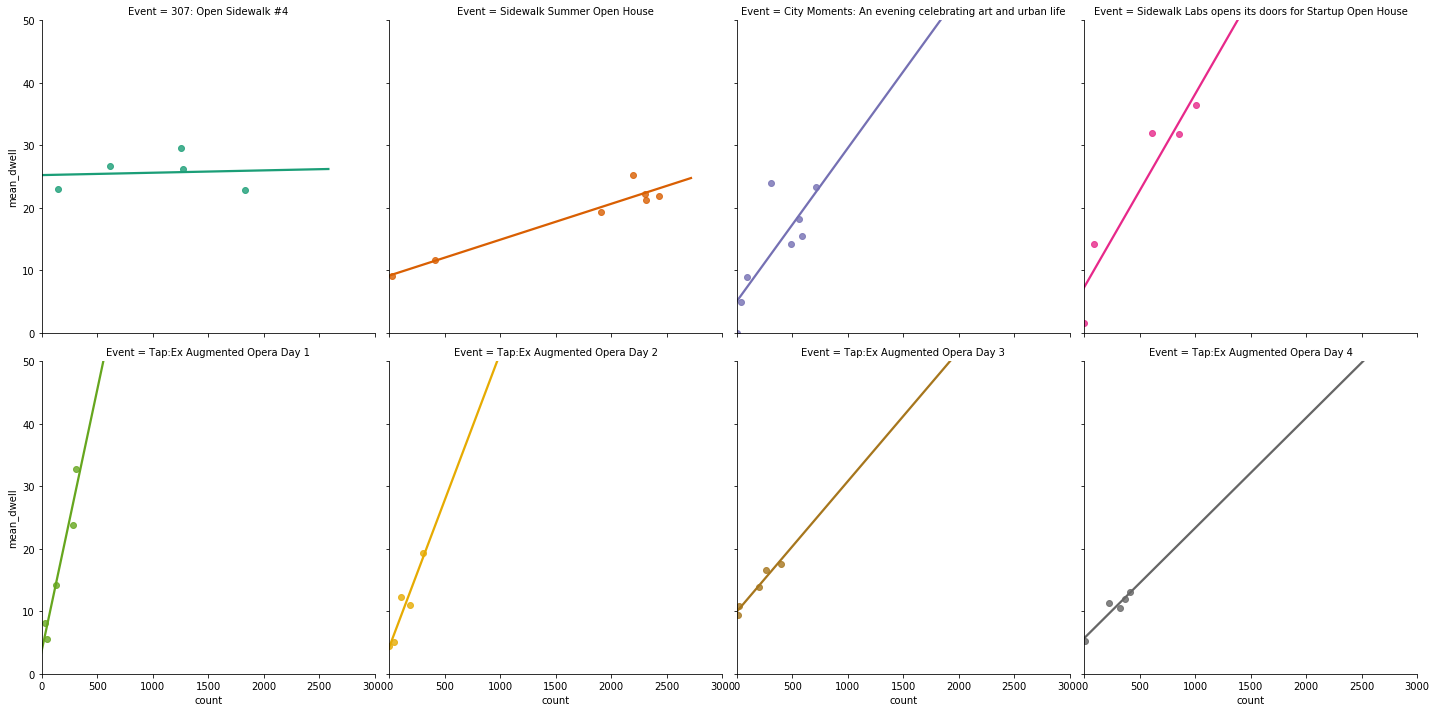

In [98]:
import seaborn as sns;
g = sns.lmplot(x="count", y="mean_dwell", hue="Event", data=feed_dwell_1h_df_event_streetscape,
               palette="Dark2", ci = None, col = "Event", col_wrap = 4)
g = g.set(xlim = (0, 3000), ylim = (0, 50))

In [99]:
feed_dwell_1d_df_streetscape = feed_dwell_1d_df[feed_dwell_1d_df['device'] == "Streetscape"]

In [100]:
def plot_dwell_time_ped_count_all_days():
    
    df = feed_dwell_1d_df_streetscape
    
    fig = make_subplots(rows = 2, cols = 1)
    
    fig.add_trace(go.Scatter(x=df['time'], y=df['mean_dwell'], 
                             name = "Dwell Time (mean)", line_color="royalblue"), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['time'], y=df['count'], 
                            name = "Pedestrian Count", line_color="dimgray"), row=2, col=1)

    df_corr = df[['count', 'mean_dwell']]
    pearson_r = df_corr.corr().iloc[0, 1]
    title = "Pearson correlation: " + str(pearson_r)
    
    fig.update_layout(height=500, width=950, title_text=title)
    fig.show()

In [101]:
plot_dwell_time_ped_count_all_days()

In [105]:
feed_dwell_1h_df_normal_time = feed_dwell_1h_df[feed_dwell_1h_df["hour"] <= 18]
feed_dwell_1h_df_normal_time = feed_dwell_1h_df_normal_time[feed_dwell_1h_df_normal_time["hour"] >= 9]

In [107]:
df_corr = feed_dwell_1h_df_normal_time[['count', 'mean_dwell']]
pearson_r = df_corr.corr().iloc[0, 1]
pearson_r

0.004787626770727069

## Maintenance Strategy

In [108]:
# need hourly data so writing the query again; can combine with the previous one later
def get_dwell_by_hour(func, ID):
    '''
    func is either feedDwellTimeDistribution or zoneDwellTimeDistribution
    '''
    if func == 'feedDwellTimeDistribution':
        arg = 'serialnos: "{0}"'.format(ID)
    else:
        arg = 'zoneIds: {0}'.format(ID)
        
    query = """
    query {{
        {0}(
        {1},
        startTime: "2019-02-20T00:00:00",
        endTime: "2020-01-12T00:00:00",
        timezone: "America/New_York",
        objClasses: ["pedestrian"],
        interval: "1h"
        ){{
        edges {{
          node {{
            time
            objClass
            pct100
            pct75
            pct50
            pct25
            mean
            count
          }}
        }}
      }}
    }}
    """.format(func, arg)

    dwell = requests.post(url, json={'query': query}, 
                           headers = {'Authorization':token})
    
    df = pd.DataFrame([x['node'] for x in dwell.json()['data'][func]['edges']])
    if func == 'feedDwellTimeDistribution':
        df['device'] = ID
    else:
        df['zone'] = ID
    
    return df

In [109]:
feed_dwell_df = pd.concat([get_dwell_by_hour('feedDwellTimeDistribution', device_ids[i]) 
                           for i in range(3)])

In [110]:
# replace NaN with 0
feed_dwell_df = feed_dwell_df.fillna(0)

# convert time to timestamp object
feed_dwell_df['time'] = feed_dwell_df['time'].str[:-6].apply(lambda x : pd.Timestamp(x))

# add name column in addition to ID
feed_dwell_df['device_name'] = [device_dict[d] for d in feed_dwell_df.device]

In [111]:
import datetime as dt
from pandas.api.types import CategoricalDtype
days = [(dt.datetime(2019, 3, 4) + dt.timedelta(days=x)).strftime('%a') for x in range(0, 7)]
day_type = CategoricalDtype(categories=days, ordered=True)

feed_dwell_df['day of week'] = feed_dwell_df['time'].apply(lambda x: x.strftime('%a')).astype(day_type)
feed_dwell_df['date'] = feed_dwell_df['time'].apply(lambda x: x.strftime('%Y-%m-%d'))
feed_dwell_df['hour'] = feed_dwell_df['time'].apply(lambda x: x.strftime('%H'))
feed_dwell_df['hour'] = pd.to_numeric(feed_dwell_df['hour'])

In [112]:
daily_count = feed_dwell_df.groupby(['date', 'device_name'])['count'].max()
daily_count = pd.DataFrame(daily_count).reset_index()
daily_count['date'] = pd.to_datetime(daily_count['date'])

In [113]:
def maintenance_df(df, device, threshold, service):
    dev_df = df[df['device_name'] == device]
    
    need_extra = []
    need_regular = []
    unmaintained = []
    visualize = []
    cumulative = 0

    for index, row in dev_df.iterrows():
        if row['count'] >= threshold:
            need_extra.append(1)
            need_regular.append(0)
            if service == 'both' or service == 'extra':
                visualize.append(row['count'])
            else:
                visualize.append(0)
            cumulative = 0

        else:
            need_extra.append(0)
            cumulative += row['count']
            if cumulative >= threshold:
                need_regular.append(1)
                if service == 'both' or service == 'regular':
                    visualize.append(cumulative)
                else:
                    visualize.append(0)
                cumulative = 0
            else:
                visualize.append(0)
                need_regular.append(0)

        unmaintained.append(cumulative)

    dev_df['need_extra'] = need_extra
    dev_df['need_regular'] = need_regular
    dev_df['unmaintained'] = unmaintained
    dev_df['visualize'] = visualize
        
    return dev_df

In [114]:
def plot_maintenance(start_date, end_date, threshold, service):
    #df = nonzero_df
    df = daily_count
        
    plot_df = df.loc[(df.date >= pd.Timestamp(start_date)) & 
                     (df.date <= pd.Timestamp(end_date))].copy()
    
    dev1 = maintenance_df(plot_df, 'Streetscape', threshold, service)
    dev2 = maintenance_df(plot_df, 'Under Raincoat', threshold, service)
    dev3 = maintenance_df(plot_df, 'Outside', threshold, service)
    
    dev_y = ['Streetscape', 'Under Raincoat', 'Outside']
    dev_y = dev_y[::-1]
    dev_z = [dev1['visualize'], dev2['visualize'], dev3['visualize']]
    dev_z = dev_z[::-1]

    fig = go.Figure(data=go.Heatmap(
            z=dev_z,
            x=dev3['date'],
            y=dev_y,
            colorscale='Hot_r'))

    fig.update_layout(
        title='Maintenance Schedule',
        xaxis_nticks=36)
    
    fig.show()

In [115]:
_ = interact(plot_maintenance, 
             service=widgets.Dropdown(options=['both', 'extra', 'regular'], value='both', disabled=False),
             start_date=widgets.DatePicker(value=pd.to_datetime('2019-02-20')),
             end_date=widgets.DatePicker(value=pd.to_datetime('2020-01-12')),
             threshold=widgets.IntSlider(value=500, min=300, max=1000, step=100, readout_format='d')
            )

We plan to have regular maintenance once for every 500 visitors, and extra maintenance on days with more than 500 visitors on a single day. On the interactive plot, the user can select 'both' to view all the maintenance needed, or 'extra' and 'regular' to see maintenance of a specific type. 

We can see that Under Raincoat need the least maintenance, once every week during busy months, and twice or even once every month during less busy months. Streetscape needs the most maintenance. 

The color intensity represents the number of visitors for every maintenance, and the darker the colour, the more thorough the maintenance may need to be. 

The user can also change the threshold to visualize the change of maintenance freqency under different requirements, to plan the desired maintenance schedule.

In [116]:
def plot_hour_heatmap(selected, start_date, end_date):
    df = feed_dwell_df
        
    plot_df = df.loc[(pd.to_datetime(df.date) >= pd.Timestamp(start_date)) & 
                     (pd.to_datetime(df.date) <= pd.Timestamp(end_date))].copy()
    
    fig = go.Figure()
    
    if selected == 'all':
        sub_df = plot_df.copy()
    else:
        sub_df = plot_df[plot_df['device_name'] == selected]
        
    hourly_count = sub_df.groupby(['day of week', 'hour'])['count'].mean()
    hourly_count = pd.DataFrame(hourly_count).reset_index()
        
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    days = days[::-1]
    count = []
    count = count[::-1]
    
    for day in days:
        count.append(hourly_count[hourly_count['day of week'] == day]['count'].tolist())
        
    #print(count)

    fig = go.Figure(data=go.Heatmap(
                   z=count,
                   y=days,
                   x=[0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23],
                   colorscale='YlOrRd',
                   hoverongaps = False))
    
    fig.update_layout(
        title="Pedestrian count by hour and day of week",
        xaxis = dict(
        tickmode = 'linear',
        dtick = 1,
        title = 'hour in the day')
    )
    
    fig.show()

In [117]:
_ = interact(plot_hour_heatmap, 
             selected=widgets.Dropdown(options=['all', 'Streetscape', 'Under Raincoat', 'Outside'], 
                                       value='all', disabled=False),
             start_date=widgets.DatePicker(value=pd.to_datetime('2019-02-20')),
             end_date=widgets.DatePicker(value=pd.to_datetime('2020-01-12'))
            )

Ideally, we want to plan for a regular maintenance time during the day, so we visualize the hourly count by hour and by day of the week using a calendar heatmap. For Streetscape, there are more people on Sunday afternoons, probably because of the visitors attending open hours. 

There are more activities during 8:00-20:00, and we would recommend scheduling the maintenance time during 7:00-8:00.